In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Ensures that the display width isn't restricted
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [4]:
scan = set(['ipsweep', 'portsweep', 'nmap', 'satan'])
dos = set(['neptune', 'smurf', 'pod', 'teardrop', 'land'])
access = set(['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezclient', 'warezmaster'])
exploit = set(['buffer_overflow', 'loadmodule', 'rootkit', 'perl'])
backdoor = set(['back','spy'])

df['attack_category'] = None

for i in range(len(df)):
  attk = df.loc[i,'attack']
  if attk in scan:
    df.loc[i,'attack_category'] = 'scan'
  elif attk in dos:
    df.loc[i,'attack_category'] = 'dos'
  elif attk in access:
    df.loc[i,'attack_category'] = 'access'
  elif attk in exploit:
    df.loc[i,'attack_category'] = 'exploit'
  elif attk in backdoor:
    df.loc[i,'attack_category'] = 'backdoor'
  else:
    df.loc[i,'attack_category'] = 'normal'

In [5]:
X = df.drop(['attack','attack_category'],axis=1)
y = df['attack_category']

In [6]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['protocoltype', 'service', 'flag']

encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=1,k_neighbors=5)
X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train) #_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [10]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_smt[numerical_columns] = scaler.fit_transform(X_train_smt[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=3000)
model.fit(X_train_smt, y_train_smt)

LogisticRegression(max_iter=3000)

In [12]:
y_pred = model.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9809


In [14]:
name_labels = [target_encoder.classes_[i] for i in range(0,6)]
name_labels

['access', 'backdoor', 'dos', 'exploit', 'normal', 'scan']

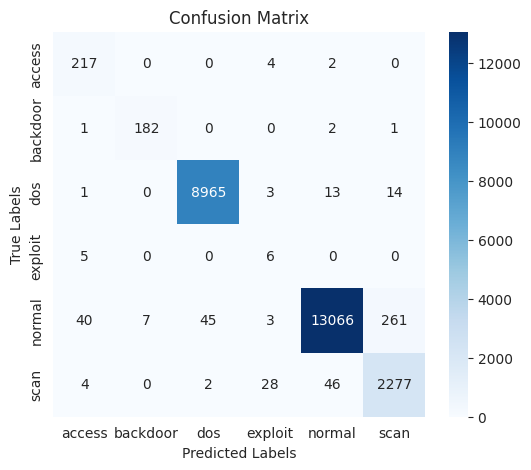

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=name_labels, yticklabels=name_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=name_labels))

              precision    recall  f1-score   support

      access       0.81      0.97      0.88       223
    backdoor       0.96      0.98      0.97       186
         dos       0.99      1.00      1.00      8996
     exploit       0.14      0.55      0.22        11
      normal       1.00      0.97      0.98     13422
        scan       0.89      0.97      0.93      2357

    accuracy                           0.98     25195
   macro avg       0.80      0.91      0.83     25195
weighted avg       0.98      0.98      0.98     25195



In [17]:
# df['is_attack'] = df['attack'].apply(lambda x: 0 if x=='normal' else 1)
# df['is_attack'].value_counts()